In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
plt.style.use('figures.mplstyle')
import leptoninjector as LI
from MuonSimulationHelpers import *
from GeometryHelpers import xyz_to_lat_long

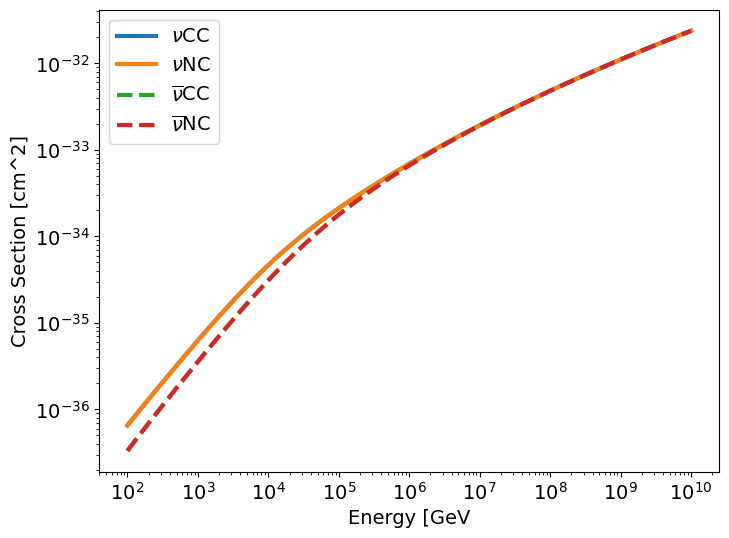

In [2]:
Erange = np.logspace(2,10,100)
for k in DIS_xs:
    if 'bar' in k:
        xs = np.array([DIS_xs[k].TotalCrossSection(numubar,E,target_type) for E in Erange])
        plt.plot(Erange,xs,label=r'$\overline{\nu}$' + k[-2:],ls='--')
#         for primary,tag in zip([nuebar,numubar,nutaubar],
#                                [r'$\overline{\nu}_e$',r'$\overline{\nu}_\mu$',r'$\overline{\nu}_\tau$']):
            
#             xs = np.array([DIS_xs[k].TotalCrossSection(primary,E,target_type) for E in Erange])
#             plt.plot(Erange,xs,label=tag + k[-2:],ls='--')
    else:
        xs = np.array([DIS_xs[k].TotalCrossSection(numu,E,target_type) for E in Erange])
        plt.plot(Erange,xs,label=r'$\nu$' + k[-2:])
#         for primary,tag in zip([nue,numu,nutau],
#                                [r'$\nu_e$',r'${\nu}_\mu$',r'${\nu}_\tau$']):
            
#             xs = np.array([DIS_xs[k].TotalCrossSection(primary,E,target_type) for E in Erange])
#             plt.plot(Erange,xs,label=tag + k[-2:])
plt.loglog()
plt.legend()
plt.xlabel('Energy [GeV')
plt.ylabel('Cross Section [cm^2]')
plt.show()

In [3]:
light_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_SIBYLL_light.parquet')
charm_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_SIBYLL_charm.parquet')
Nl = np.sum(light_simulation.data["DIS_distance"]!=0)
Nc = np.sum(charm_simulation.data["DIS_distance"]!=0)
assert(Nl==Nc)
N = Nl
print(N)

20001


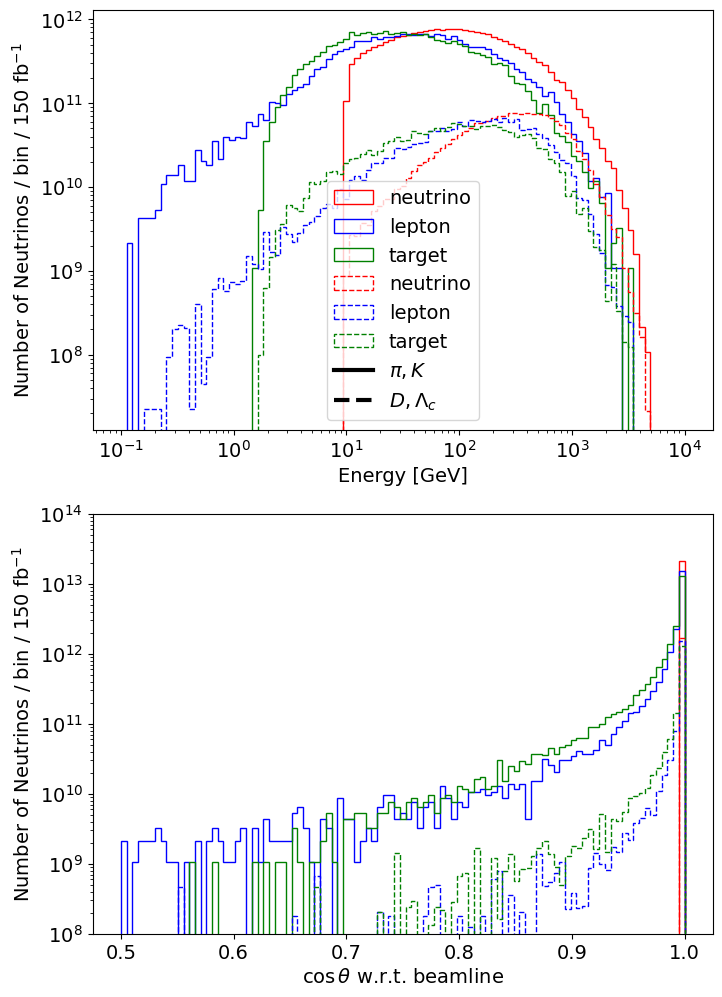

In [4]:
ls_arr = ['solid','dashed']
fig,ax = plt.subplots(2,1,figsize=(8,12))
for i,simulation in enumerate([light_simulation,charm_simulation]):
    
    simulation.EnsureUnitHadDir()
    simulation.EnsureUnitLepDir()
    simulation.EnsureUnitNeutrinoDir()
    
    
    kwargs = {'bins':np.logspace(-1,4,100),
              'histtype':'step',
              'ls':ls_arr[i],
              'weights':simulation.data['wgt']*150*1000}

    ax[0].hist(simulation.data['E'],color='r',label='neutrino',**kwargs)
    wnorm = sum(kwargs['weights'])/sum(simulation.data.query('E_lep>0')['wgt']*150*1000)
    kwargs['weights']*=wnorm
    ax[0].hist(simulation.data['E_lep'],color='b',label='lepton',**kwargs)
    ax[0].hist(simulation.data['E_had'],color='g',label='target',**kwargs)
    
    kwargs = {'bins':np.linspace(0.5,1,100),
              'histtype':'step',
              'ls':ls_arr[i],
              'weights':simulation.data['wgt']*150*1000}
    
    ax[1].hist(simulation.data['uz'],color='r',**kwargs)
    wnorm = sum(kwargs['weights'])/sum(simulation.data.query('E_lep>0')['wgt']*150*1000)
    kwargs['weights']*=wnorm
    ax[1].hist(simulation.data['uz_lep'],color='b',**kwargs)
    ax[1].hist(simulation.data['uz_had'],color='g',**kwargs)

ax[0].plot([],[],color='black',label=r'$\pi,K$')
ax[0].plot([],[],color='black',ls='--',label=r'$D,\Lambda_c$')
ax[0].set_xlabel('Energy [GeV]')
ax[0].set_ylabel(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
ax[0].loglog()
ax[0].legend()

ax[1].set_xlabel(r'$\cos\theta$ w.r.t. beamline')
ax[1].set_ylabel(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
ax[1].set_ylim(1e8,1e14)
ax[1].semilogy()

plt.show()

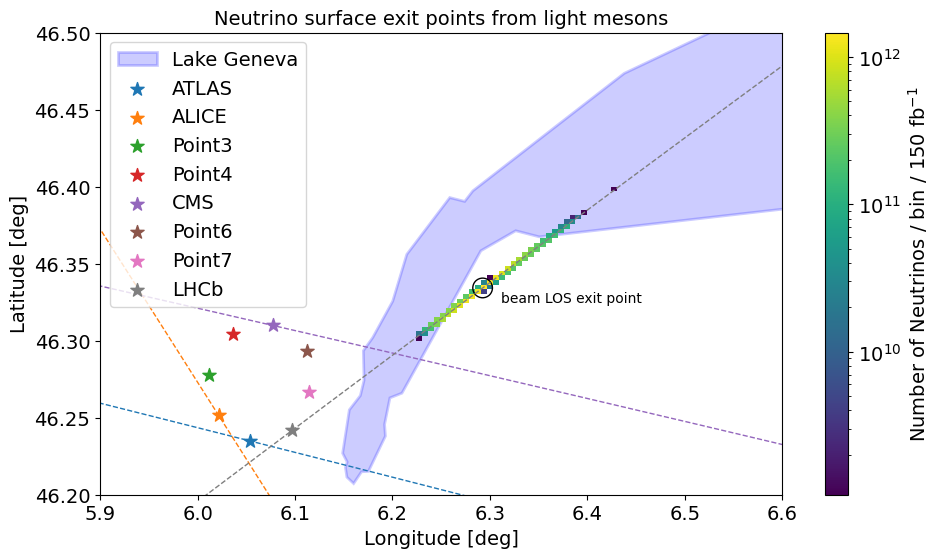

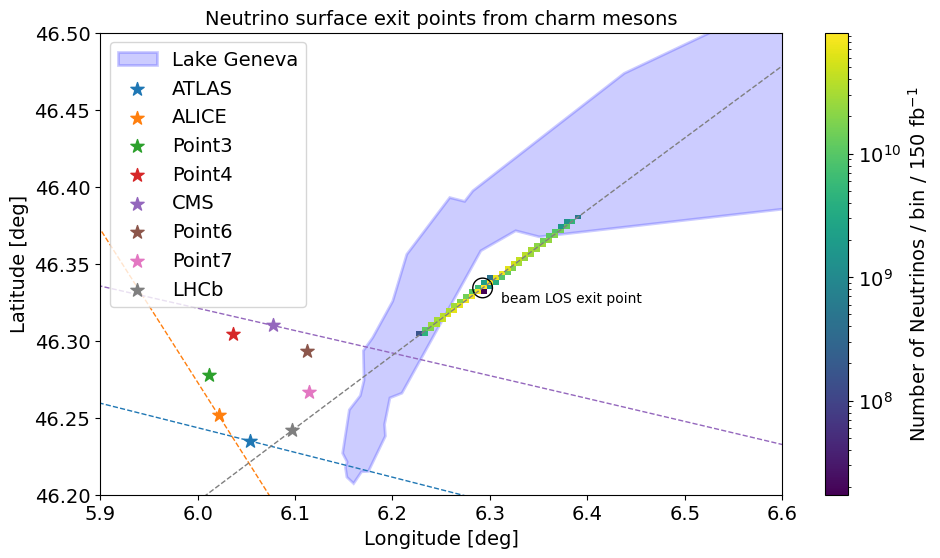

In [5]:
for simulation,tag in zip([light_simulation,charm_simulation],
                          ['light','charm']):
    fig = plt.figure(figsize=(11,6))
    plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
             list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
             color='blue',label='Lake Geneva',alpha=0.2,linewidth=2)
    for k,color in zip(list(LHC_data.index),mcolors.TABLEAU_COLORS):
        lines = plot_tangent_line_lat_long(LHC,
                                           np.array(LHC_data.loc[k,['X','Y','Z']]),
                                           np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                           limit=1 if 'Point' in k else 60000)
        center, earth_points = lines[0] # all lines are essentially the same
        plt.plot([p[1] for p in earth_points],
                [p[0] for p in earth_points],color=color,ls='--',lw=1)
        plt.scatter(center[1],
                    center[0],
                    marker='*',color=color,label=k)
        if 'Point' in k: continue # don't consider points without collisions
        int1,int2 = calculate_intersections_with_lake(LHC,
                                                    np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                    np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                    np.array(Lake_data[['Latitude','Longitude']]),
                                                    limit=50000000)
    plt.xlabel('Longitude [deg]')
    plt.ylabel('Latitude [deg]')
    plt.legend(loc='upper left')
    plt.title('Neutrino surface exit points from %s mesons'%tag,fontsize=14)
    plt.hist2d([x[1] for x in simulation.data['surface_intersection_lat_long'][:N]],
               [x[0] for x in simulation.data['surface_intersection_lat_long'][:N]],
               bins=(np.linspace(6.0,6.6,100),np.linspace(46.2,46.5,100)),
               weights = (simulation.data['wgt']*150*1000)[:N]*len(simulation.data)/N,
               norm=matplotlib.colors.LogNorm())
    c = plt.colorbar()
    c.set_label(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
    simulation.CalculateBeamExitPointFromIP('LHCb')
    plt.scatter(simulation.beam_exit_point_lat_long[1],simulation.beam_exit_point_lat_long[0],marker='o',facecolors='none',edgecolors='black',s=200)
    plt.text(1.003*simulation.beam_exit_point_lat_long[1],0.9998*simulation.beam_exit_point_lat_long[0],'beam LOS exit point')
    plt.xlim(5.9,6.6)
    plt.ylim(46.2,46.5)
    plt.show()


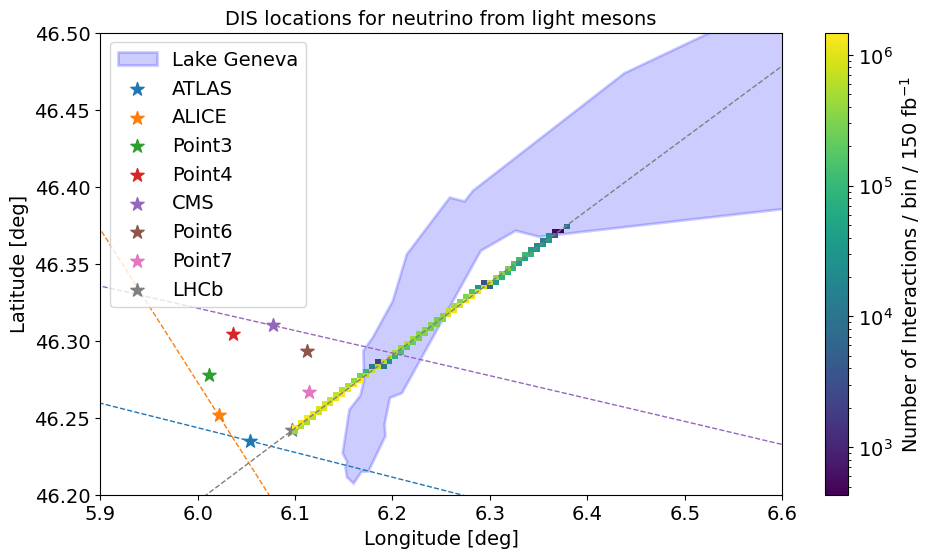

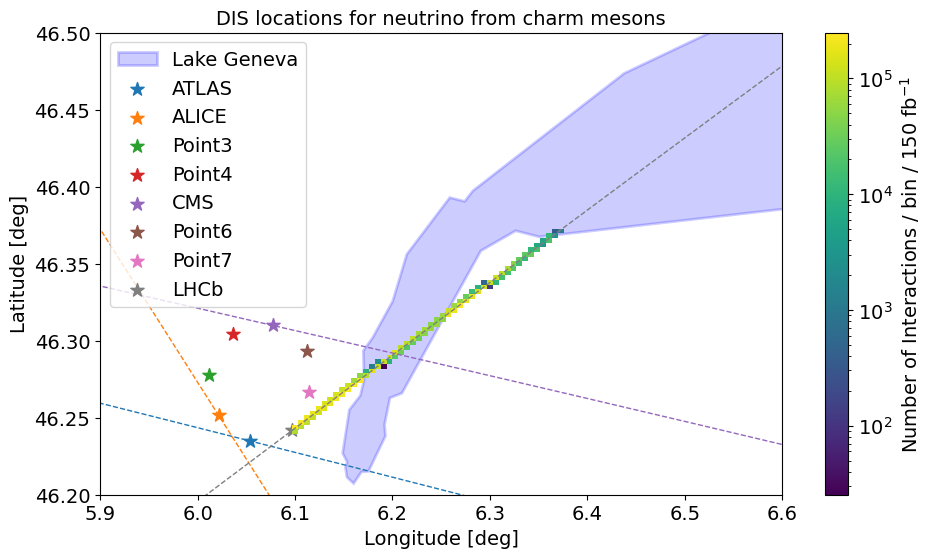

In [6]:
for simulation,tag in zip([light_simulation,charm_simulation],
                          ['light','charm']):
    fig = plt.figure(figsize=(11,6))
    plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
             list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
             color='blue',label='Lake Geneva',alpha=0.2,linewidth=2)
    for k,color in zip(list(LHC_data.index),mcolors.TABLEAU_COLORS):
        lines = plot_tangent_line_lat_long(LHC,
                                           np.array(LHC_data.loc[k,['X','Y','Z']]),
                                           np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                           limit=1 if 'Point' in k else 60000)
        center, earth_points = lines[0] # all lines are essentially the same
        plt.plot([p[1] for p in earth_points],
                [p[0] for p in earth_points],color=color,ls='--',lw=1)
        plt.scatter(center[1],
                    center[0],
                    marker='*',color=color,label=k)
        if 'Point' in k: continue # don't consider points without collisions
        int1,int2 = calculate_intersections_with_lake(LHC,
                                                    np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                    np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                    np.array(Lake_data[['Latitude','Longitude']]),
                                                    limit=50000000)
    plt.xlabel('Longitude [deg]')
    plt.ylabel('Latitude [deg]')
    plt.legend(loc='upper left')
    plt.title('DIS locations for neutrino from %s mesons'%tag,fontsize=14)
    plt.hist2d([xyz_to_lat_long(*x)[1] for x in simulation.data['DIS_location'][:N]],
               [xyz_to_lat_long(*x)[0] for x in simulation.data['DIS_location'][:N]],
               bins=(np.linspace(6.0,6.6,100),np.linspace(46.2,46.5,100)),
               weights = (simulation.data['interaction_probability']*simulation.data['wgt']*150*1000)[:N]*len(simulation.data)/N,
               norm=matplotlib.colors.LogNorm())
    c = plt.colorbar()
    c.set_label(r'Number of Interactions / bin / 150 fb$^{-1}$')
    plt.xlim(5.9,6.6)
    plt.ylim(46.2,46.5)
    plt.show()

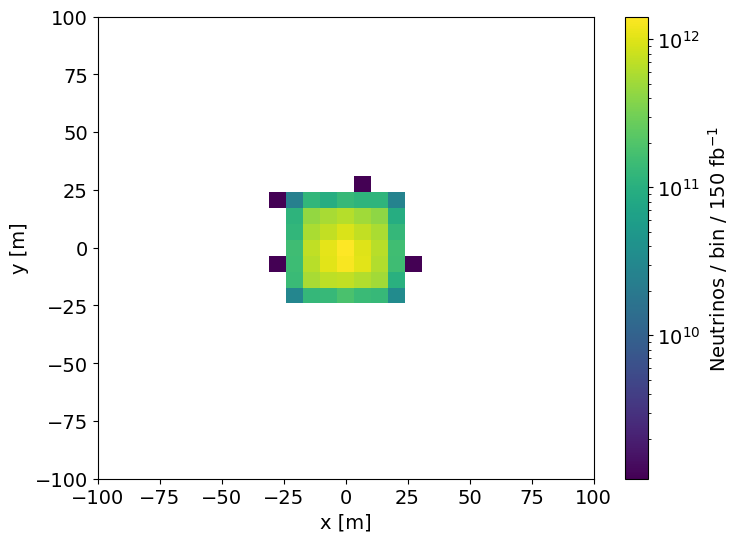

75066.92041150894
232781.9249752406
446858.44547185546


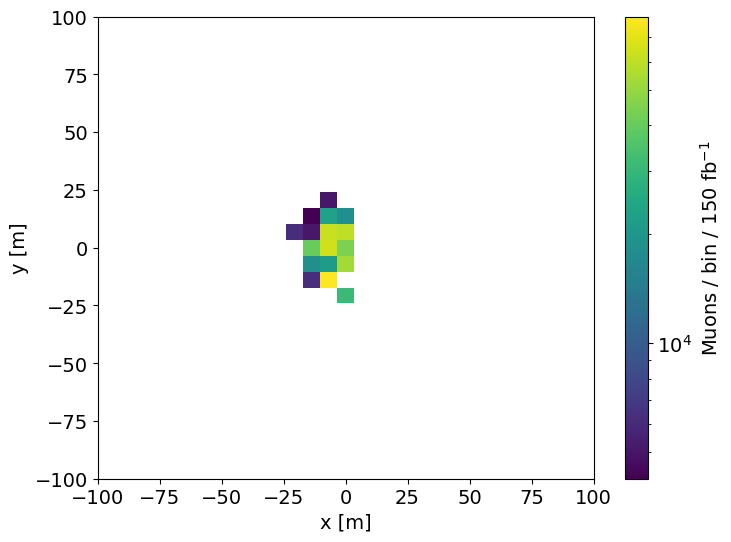

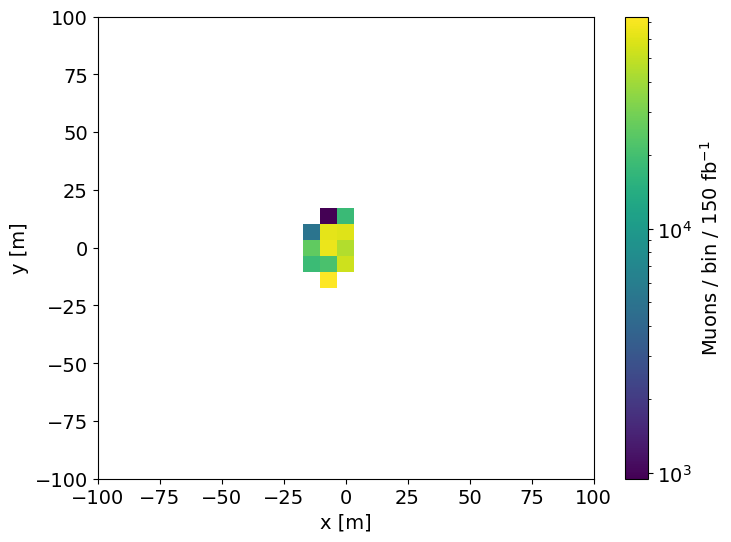

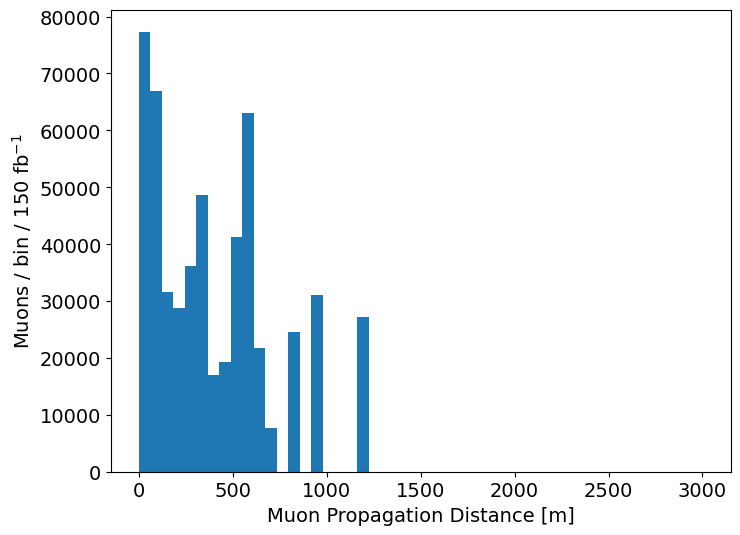

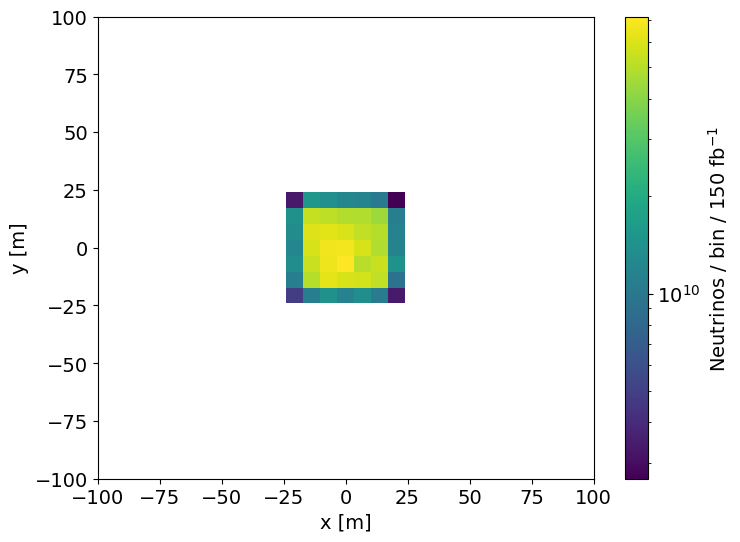

11865.6226333435
25390.221557803343
43067.12138478191


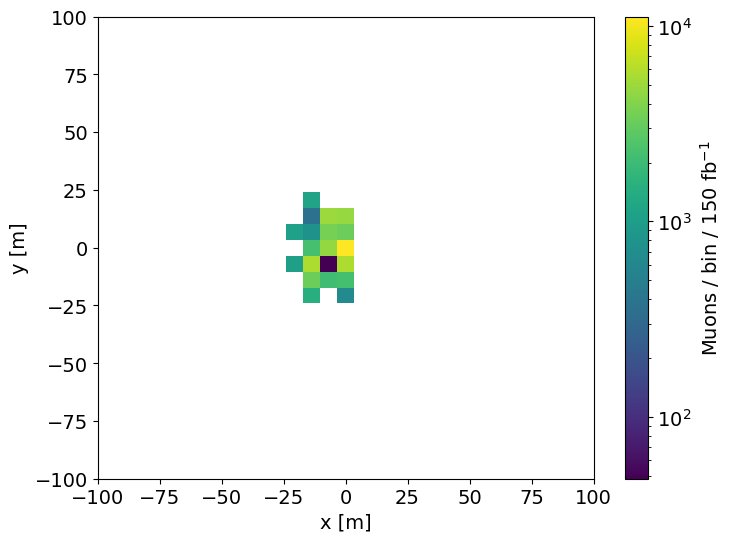

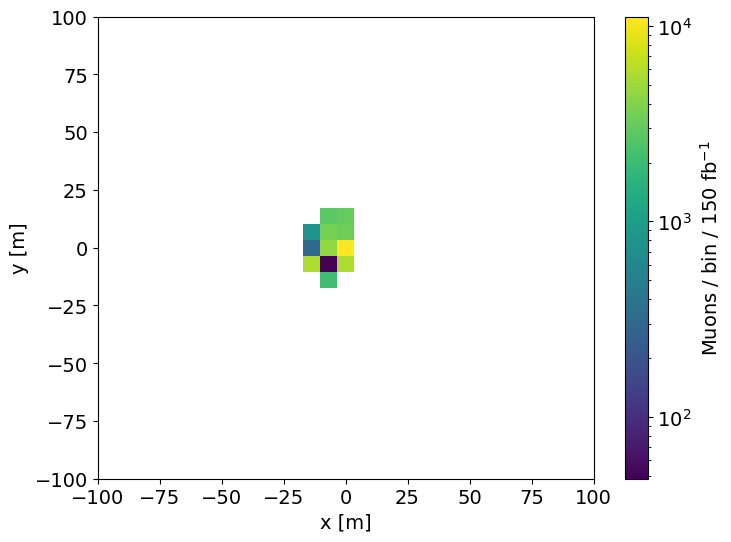

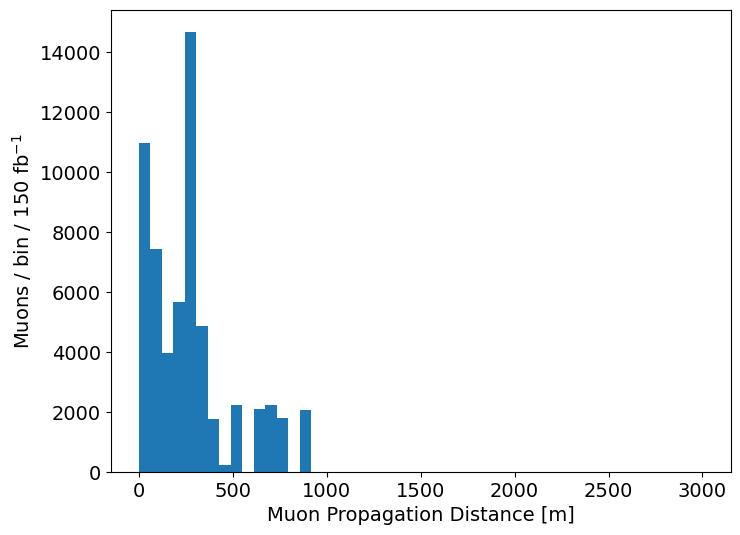

In [7]:
for simulation in [light_simulation,charm_simulation]:
    plt.hist2d(simulation.data['nu_transverse_profile_x'],
               simulation.data['nu_transverse_profile_y'],
               weights=simulation.data['nu_weight'],
               bins=np.linspace(-100,100,30),norm=matplotlib.colors.LogNorm())
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    c = plt.colorbar()
    c.set_label(r'Neutrinos / bin / 150 fb$^{-1}$')
    plt.show()

    mu_weights = np.array(simulation.data['muon_weights'])
    mu_distances = np.array(simulation.data['muon_lengths'])
    mu_profile = np.array([simulation.data['muon_transverse_profile_x'],
                           simulation.data['muon_transverse_profile_y']]).T
    
    def Xf(E,rho=1):
        return 1./(rho * 5e-4) * np.log(1 + 2e-3 * E)
    mu_ranges = Xf(simulation.data["E_lep"],rho=2.5)

    mu_weights *= mu_distances<mu_ranges
    mu_radius = np.sqrt(np.sum(mu_profile**2,axis=-1))
    for rad_cut in [5,10,15]:
        fid_weights = (mu_weights * (mu_radius<rad_cut))
        print(sum(fid_weights))

    plt.hist2d(mu_profile[:,0],mu_profile[:,1],weights=mu_weights,bins=np.linspace(-100,100,30),norm=matplotlib.colors.LogNorm())
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    c = plt.colorbar()
    c.set_label(r'Muons / bin / 150 fb$^{-1}$')
    plt.show()

    plt.hist2d(mu_profile[:,0],mu_profile[:,1],weights=fid_weights,bins=np.linspace(-100,100,30),norm=matplotlib.colors.LogNorm())
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    c = plt.colorbar()
    c.set_label(r'Muons / bin / 150 fb$^{-1}$')
    plt.show()

    plt.hist(mu_distances,bins=np.linspace(0,3000,50),weights=mu_weights)
    plt.xlabel('Muon Propagation Distance [m]')
    plt.ylabel(r'Muons / bin / 150 fb$^{-1}$')
    plt.show()

[]

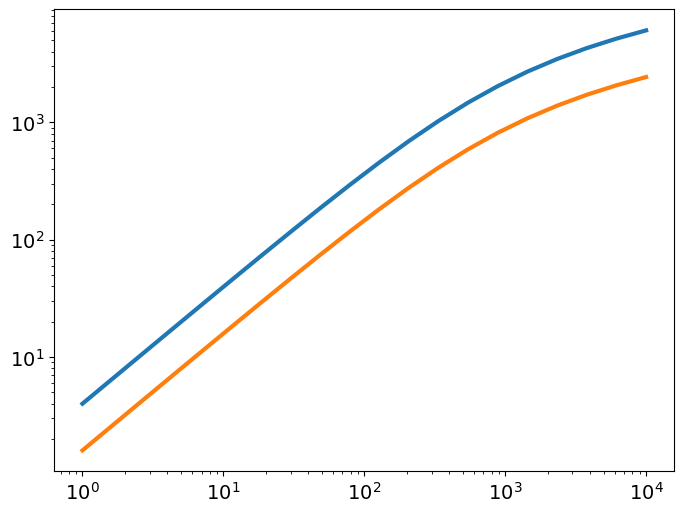

In [8]:
def Xf(E,rho=1):
    return 1./(rho * 5e-4) * np.log(1 + 2e-3 * E)

Erange = np.logspace(0,4,20)
plt.plot(Erange,Xf(Erange),label="water")
plt.plot(Erange,Xf(Erange,rho=2.5),label="rock")
plt.loglog()